# 关于 regressor 结构的实验

- 是否使用 feature selector
- 是否使用 adaboost
- 是否将多个模型使用 voting 组合

In [ ]:
%%shell
pip install alive_progress
wget -O data.zip -q https://github.com/YoungY620/neu-lung2022/releases/download/v0.4/data.zip
unzip -oq data.zip -d data


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%shell

wget -O models.zip -q https://github.com/YoungY620/neu-lung2022/releases/download/v0.4/models.zip
unzip -oq models.zip "simclr_encoder.pth.tar" 
unzip -oq models.zip "*.npy"

git clone https://github.com/YoungY620/neu-lung2022
cp neu-lung2022/lung/core/simclr/simclr_resnet18.py ./simclr_resnet18.py
cp neu-lung2022/lung/core/simclr/transforms.py ./transforms.py
cp neu-lung2022/lung/core/feature.py ./feature.py

fatal: destination path 'neu-lung2022' already exists and is not an empty directory.


In [ ]:
import os
import pandas as pd
from PIL import Image

def get_rating_data(index):
    data_dir = "./data/images"
    if index in ['a', 'b', 'c']:
        df = pd.read_csv("./data/bronchus.csv")
    elif index in ['d']:
        df = pd.read_csv("./data/vessel.csv")
    else:
        df = pd.read_csv("./data/overall.csv")
    pil_images, ratings = [], []
    assert index in ['a', 'b', 'c', 'd', 'e'] and index in df.columns
    df = df.dropna(subset=[index])
    filename = None
    img = None
    for i, row in df.iterrows():
        if row[index] == None: continue
        if row['file_name'] != filename:
            img = Image.open(os.path.join(
                data_dir, row['file_name'])).convert("RGB")
        ratings.append(row[index])
        if index == 'e':
            pil_images.append(img)
        else:
            pil_images.append(img.crop((row['xmin'], row['ymin'], row['xmax'], row['ymax'])))
 
    return pil_images, ratings

In [ ]:
import torch
import numpy as np

from simclr_resnet18 import ResNetSimCLR
from feature import _abstract_features, _comatrix_features, _color_ratio_feature
from transforms import get_simclr_encoding_transform

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

_m = ResNetSimCLR(64,'resnet18')
checkpoint = torch.load('./simclr_encoder.pth.tar', map_location=device)
state_dict = checkpoint['state_dict']
_m.load_state_dict(state_dict)
b_hist = np.load('background.npy')
c_hist = np.load('cytoplasm.npy')
n_hist = np.load('nucleus.npy')

def get_flatten_rating_feature(im, index):
    im = im.convert('RGB')
    grey_np_im = np.array(im.copy().convert('L'))
    _transforms = get_simclr_encoding_transform(size=1280 if index == 'e' else 80)
    tensor_im = _transforms(im.copy()).unsqueeze(0).to(device)
    ftr = []

    ftr = np.append(ftr, _abstract_features(tensor_im, _m, device)) 
    # 小秘密: 由于数据量小, 其实加上抽象特征效果更差
    ftr = np.append(ftr, _comatrix_features(grey_np_im))
    ftr = np.append(ftr, _color_ratio_feature(im, n_hist, c_hist, b_hist, rm_unnecessary=(index=='e')))
    return ftr

In [ ]:
from sklearn.model_selection import train_test_split

rating_datas = {}
test_indexes = ['a']
for ind in test_indexes:
  X_, Y = get_rating_data(ind)
  X = np.array([get_flatten_rating_feature(im, ind) for im in X_])
  rating_datas[ind] = (X, Y)

def get_split_flatten_data(index):
  X, Y = rating_datas[index]

  X.shape, np.array(Y).shape
  return train_test_split(X, Y, random_state=49, test_size=0.2)

In [ ]:
import random
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from alive_progress import alive_bar


def get_models(random_state=None):
  tr_pip = Pipeline([('discretizer', KBinsDiscretizer(n_bins=5, encode="onehot", strategy='uniform')), 
            ('tree',DecisionTreeRegressor(max_depth=5, random_state=random_state))])
  svr = SVR(C=1.0, epsilon=0.2) 
  vot_reg = VotingRegressor(estimators=[("tree",tr_pip),("svr",svr)])
  selected_mlp = make_pipeline(SelectKBest(f_regression, k=90), MLPRegressor(random_state=random_state, max_iter=500))
  model_dict = {
    "select_mlp(k=90)": selected_mlp,
    "svr": svr,
    "tree": tr_pip, 
    "voting(svr, tree)": vot_reg,
  }
  for n_boost_bin in [3, 50, 100]:
    tree_boost = AdaBoostRegressor(base_estimator=tr_pip, n_estimators=n_boost_bin)
    svr_boost = AdaBoostRegressor(base_estimator=svr, n_estimators=n_boost_bin)
    vot_boost = VotingRegressor(estimators=[("tree",tree_boost),("svr",svr_boost)])
    model_dict.update({
      f"svr_boost(n={n_boost_bin})": svr_boost,
      f"tree_boost(n={n_boost_bin})":tree_boost,
      f"vote_boost(svr, tree)(n={n_boost_bin})": vot_boost,
    })

    for kbest in [90]:
      selected_vot_boost = make_pipeline(SelectKBest(f_regression, k=kbest), VotingRegressor(estimators=[("tree",tree_boost),("svr",svr_boost)]))
      model_dict.update({f"select_vote_boost(svr, tree)(n={n_boost_bin},k={kbest})": selected_vot_boost})
  return model_dict




In [ ]:
try:
  from tqdm import tqdm_notebook as tqdm
except ImportError:
  from tqdm.notebook import tqdm

score_dict = {}
for name in get_models().keys():
  score_dict[name] = []
t = tqdm(total=30*1*len(score_dict.keys()))
for ind in test_indexes:
  X_train, X_test, y_train, y_test = get_split_flatten_data(ind)
  for seed in range(30):
    random.seed(seed)
    np.random.seed(seed)
    model_dict = get_models(random_state=seed)
    for name, model in model_dict.items():
      model.fit(X_train, y_train)
      score_dict[name].append(model.score(X_test, y_test))
      t.update()
t.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/480 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Text(0.5, 0, 'random seed')

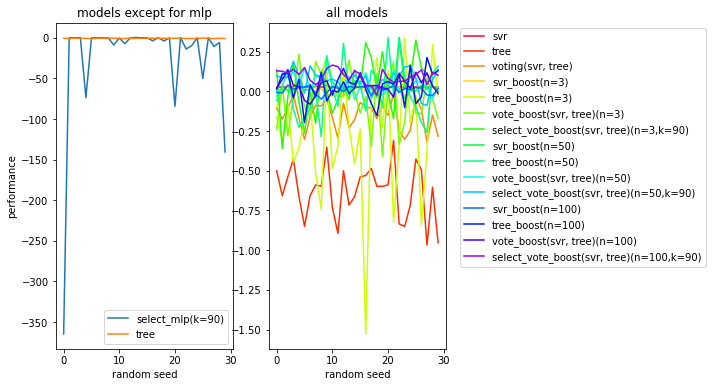

In [ ]:
import matplotlib.pyplot as plt

NUM_COLORS = len(score_dict.keys())

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=[7,6])
ax = fig.add_subplot(121)
# ax.set_prop_cycle('color', [cm(1-1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for name, scores in score_dict.items():
  if name not in ["select_mlp(k=90)", "tree"]: continue
  ax.plot([seed for seed in range(len(scores))], scores, label=name)
plt.title("models except for mlp")
ax.legend()
plt.xlabel('random seed')
plt.ylabel('performance')

ax = fig.add_subplot(122)
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for name, scores in score_dict.items():
  if name in ["select_mlp(k=90)"]: continue
  ax.plot([seed for seed in range(len(scores))], scores, label=name)
plt.title("all models")
ax.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('random seed')
# plt.ylabel('performance')


In [ ]:
import pandas as pd

pd.DataFrame(score_dict).describe()

,select_mlp(k=90),svr,tree,"voting(svr, tree)",svr_boost(n=3),tree_boost(n=3),"vote_boost(svr, tree)(n=3)","select_vote_boost(svr, tree)(n=3,k=90)",svr_boost(n=50),tree_boost(n=50),"vote_boost(svr, tree)(n=50)","select_vote_boost(svr, tree)(n=50,k=90)",svr_boost(n=100),tree_boost(n=100),"vote_boost(svr, tree)(n=100)","select_vote_boost(svr, tree)(n=100,k=90)"
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,-25.845874,0.027125,-0.627555,-0.153682,0.005181,-0.259507,-0.039907,0.037785,0.016108,0.006182,0.049913,0.073699,0.010490,0.025963,0.042351,0.095944
std,71.518841,0.000000,0.168948,0.089275,0.029448,0.385804,0.179433,0.167093,0.022204,0.166545,0.055442,0.064583,0.022553,0.094414,0.055446,0.044110
min,-364.685618,0.027125,-0.968182,-0.319797,-0.094306,-1.527354,-0.409188,-0.360084,-0.048006,-0.284595,-0.050522,-0.088258,-0.049187,-0.195194,-0.081048,-0.024579
25%,-9.421408,0.027125,-0.716426,-0.217133,-0.008300,-0.428112,-0.156213,-0.045742,0.005967,-0.106526,0.013310,0.055760,-0.007216,-0.034097,0.018619,0.065315
50%,-0.117694,0.027125,-0.597953,-0.150236,0.010815,-0.225497,-0.032098,0.021980,0.020161,-0.007838,0.032094,0.085065,0.018850,0.031526,0.037654,0.105666
75%,0.071101,0.027125,-0.507352,-0.092117,0.024966,-0.032049,0.099687,0.137238,0.033029,0.108761,0.093159,0.101203,0.028499,0.107922,0.072671,0.129709
max,0.448008,0.027125,-0.307428,-0.011836,0.049444,0.335991,0.233659,0.339248,0.046958,0.338085,0.158483,0.188734,0.040476,0.213791,0.144857,0.165530


In [ ]:
import pandas as pd

pd.DataFrame(score_dict)

,select_mlp(k=90),svr,tree,"voting(svr, tree)",svr_boost(n=3),tree_boost(n=3),"vote_boost(svr, tree)(n=3)","select_vote_boost(svr, tree)(n=3,k=90)",svr_boost(n=50),tree_boost(n=50),"vote_boost(svr, tree)(n=50)","select_vote_boost(svr, tree)(n=50,k=90)",svr_boost(n=100),tree_boost(n=100),"vote_boost(svr, tree)(n=100)","select_vote_boost(svr, tree)(n=100,k=90)"
0,-364.685618,0.027125,-0.499947,-0.105753,-0.094306,-0.161939,-0.240008,0.137764,-0.029893,-0.059327,0.001868,0.098929,-0.007398,0.014176,0.020035,0.129049
1,0.072108,0.027125,-0.657189,-0.175824,-0.009569,-0.310750,0.047004,-0.360084,0.025935,0.033677,0.115696,0.084155,-0.009342,0.107440,0.074798,0.126443
2,-0.143170,0.027125,-0.538716,-0.102315,0.028381,-0.084362,-0.280654,-0.036739,0.005219,0.132774,0.089900,0.087927,0.040476,0.117978,0.136692,0.113880
3,0.279111,0.027125,-0.425902,-0.023248,0.018804,-0.445399,-0.033393,0.182376,0.003128,-0.112052,0.123211,0.188734,0.013421,-0.041322,0.038344,0.139280
4,-73.532377,0.027125,-0.662849,-0.169977,-0.008838,-0.356390,0.233659,-0.070833,0.033981,-0.226225,0.031629,0.096856,0.023530,0.076171,0.031427,0.105702
5,-0.092217,0.027125,-0.849709,-0.302276,0.008627,-0.173355,-0.099950,-0.263875,0.007736,-0.167787,0.148931,-0.010649,0.028885,-0.195194,-0.056197,0.150066
6,-0.038847,0.027125,-0.657189,-0.161749,0.016032,-0.044297,-0.161481,-0.004039,0.012989,-0.109198,0.000863,0.160266,0.036328,0.042127,-0.081048,0.069684
7,-0.017809,0.027125,-0.588803,-0.087472,0.024533,-0.514171,0.189411,-0.201378,0.036329,0.004054,0.096655,0.102539,-0.015389,-0.033666,-0.028388,0.042804
8,0.115964,0.027125,-0.597953,-0.092117,0.015043,-0.740811,0.103762,0.126651,0.046958,-0.284595,0.078690,0.094481,-0.049187,0.118715,0.055796,0.069593
9,-8.803363,0.027125,-0.351856,-0.050136,-0.022682,0.126830,0.214916,-0.003623,0.037486,0.224627,0.158483,0.066871,-0.007626,-0.059917,0.066290,0.144501


In [ ]:
pd.DataFrame(score_dict).to_csv("./model_scores-100.csv")

In [ ]:
import numpy as np

criteria_dict = {}
criteria_dict["mean"] = []
criteria_dict["std"] = []
criteria_dict["positive_ratio"] = []

for name, scores in score_dict.items():
  criteria_dict["mean"].append(np.mean(scores))
  criteria_dict['std'].append(np.std(scores))
  criteria_dict["positive_ratio"].append(np.count_nonzero(np.array(scores)>0)/len(scores))

pd.DataFrame(criteria_dict, index=score_dict.keys())

,mean,std,positive_ratio
select_mlp(k=90),-25.845874,70.316758,0.366667
svr,0.027125,0.000000,1.000000
tree,-0.627555,0.166109,0.000000
"voting(svr, tree)",-0.153682,0.087774,0.000000
svr_boost(n=3),0.005181,0.028953,0.633333
tree_boost(n=3),-0.259507,0.379320,0.200000
"vote_boost(svr, tree)(n=3)",-0.039907,0.176417,0.400000
"select_vote_boost(svr, tree)(n=3,k=90)",0.037785,0.164284,0.600000
svr_boost(n=50),0.016108,0.021831,0.900000
tree_boost(n=50),0.006182,0.163746,0.500000


<BarContainer object of 16 artists>

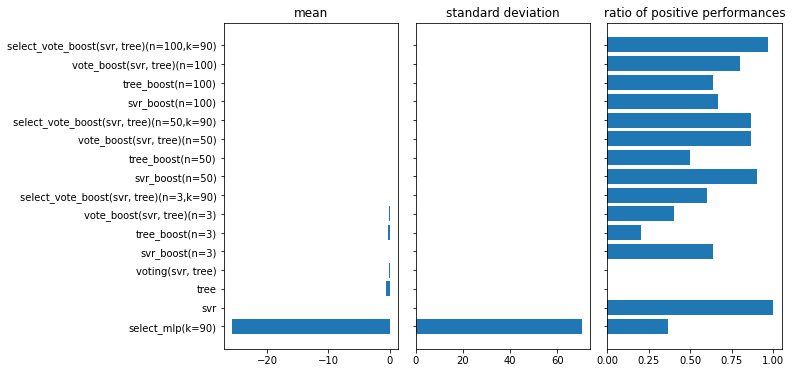

In [ ]:

fig = plt.figure(figsize=[10,6])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.1, hspace=0)
ax = fig.add_subplot(131)
plt.title("mean")
ax.barh(range(len(score_dict.keys())), criteria_dict['mean'], tick_label=list(score_dict.keys()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
ax = fig.add_subplot(132)
plt.title("standard deviation")
ax.barh(range(len(score_dict.keys())), criteria_dict['std'], tick_label=[""]*len(score_dict.keys()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
ax = fig.add_subplot(133)
plt.title("ratio of positive performances")
ax.barh(range(len(score_dict.keys())), criteria_dict['positive_ratio'], tick_label=[""]*len(score_dict.keys()))
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)